In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset,Dataset
import matplotlib.pyplot as plt
import mlflow

# Define the input tensors for stocks and sales
n = 1000
torch.manual_seed(0)
stocks = torch.randint(0, 10, (n,))
demand = torch.poisson(torch.ones(n) * 2.0)
sales = torch.min(demand, stocks)

In [9]:
def poisson_loss(predictions, sales, stocks):
   def forecast_loss(predictions, sales, stocks):
    epsilon = 1e-10  # Small constant to avoid log(0)

    # Calculate the mean of the Poisson distribution based on predictions
    lambda_ = torch.exp(predictions)

    # Poisson loss formula
    poisson_loss = lambda_ - sales * torch.log(lambda_ + epsilon)

    # Mean of the Poisson loss across all examples
    poisson_loss = torch.mean(poisson_loss)

    # Exceeded stock penalty
    exceeded_stock_penalty = torch.mean(torch.max(predictions - stocks, torch.zeros_like(predictions)))

    # Combine Poisson loss and exceeded stock penalty
    loss = poisson_loss + exceeded_stock_penalty

def mse_loss_function(predictions,sales,stocks):
    mse_loss = nn.functional.mse_loss(predictions, sales)
    exceeded_stock_penalty = torch.mean(torch.max(predictions - stocks, torch.zeros_like(predictions)))
    loss = mse_loss + exceeded_stock_penalty
    return loss


def forecast_loss(predictions, sales, stocks, loss_function="poisson"):
    if loss_function =="poisson":
        return poisson_loss(predictions,sales,stocks)
    else:
        #mse loss by default
        return mse_loss_function(predictions,sales,stocks)
    



In [3]:
class MeanModel(nn.Module):
   def __init__(self):
       super(MeanModel, self).__init__()
       self.mean = nn.Parameter(torch.randn(1))
   def forward(self, n):
       return self.mean * torch.ones(n)

## comparring MSE and Poisson loss functions:

poisson
Epoch [10/100], Loss: 0.9457857608795166
Epoch [20/100], Loss: 0.8951282501220703
Epoch [30/100], Loss: 0.84860759973526
Epoch [40/100], Loss: 0.8190160989761353
Epoch [50/100], Loss: 0.7997195720672607
Epoch [60/100], Loss: 0.7868951559066772
Epoch [70/100], Loss: 0.7782448530197144
Epoch [80/100], Loss: 0.7723409533500671
Epoch [90/100], Loss: 0.7682734131813049
Epoch [100/100], Loss: 0.765449583530426
mse
Epoch [10/100], Loss: 2.535799264907837
Epoch [20/100], Loss: 2.3566436767578125
Epoch [30/100], Loss: 2.2496731281280518
Epoch [40/100], Loss: 2.182304620742798
Epoch [50/100], Loss: 2.137329339981079
Epoch [60/100], Loss: 2.1073029041290283
Epoch [70/100], Loss: 2.0872573852539062
Epoch [80/100], Loss: 2.0738742351531982
Epoch [90/100], Loss: 2.064939498901367
Epoch [100/100], Loss: 2.0589747428894043


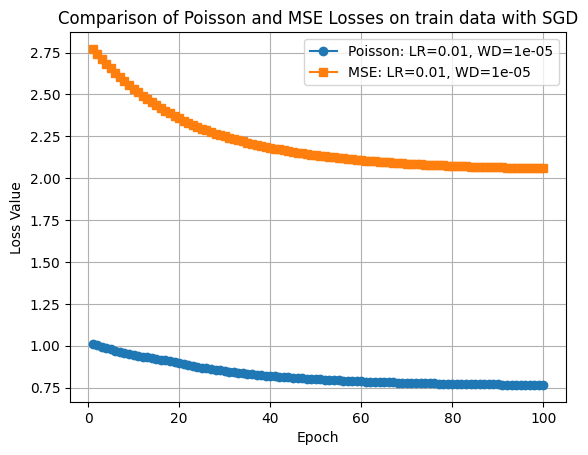

In [76]:
lr = 0.01
num_epochs = 100
optimzer_name = "SGD"
weight_decay = 1e-05
poisson_losses, mse_losses = [],[]

model = MeanModel()
if optimzer_name == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=lr,weight_decay=weight_decay)
elif optimzer_name=="adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
else:
    raise ValueError(f"Unsupported optimizer: {optimzer_name}")

losses = []
for loss_function in ["poisson", "mse"]:
    print(loss_function)
    for epoch in range(num_epochs):
   
        optimizer.zero_grad()
        outputs = model(n)
        loss = forecast_loss(outputs, sales, stocks,loss_function)
            
        loss.backward()
        optimizer.step()
        #mlflow.log_metric("loss", loss.item(), step=epoch)
        if loss_function=="poisson":
            poisson_losses.append(loss.item())
        else:
            mse_losses.append(loss.item())
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


epochs = range(1, num_epochs + 1)
# Plot Poisson losses in blue
plt.plot(epochs, poisson_losses, label=f'Poisson: LR={lr}, WD={weight_decay}', marker='o')

# Plot MSE losses in red
plt.plot(epochs, mse_losses, label=f'MSE: LR={lr}, WD={weight_decay}', marker='s')

plt.title('Comparison of Poisson and MSE Losses on train data with SGD')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()

## hyperparameter tuning
### optimizer: SGD, loss function: poisson loss

Epoch: 0, Validation Loss: 0.7223484516143799, MAE: 1.4208835363388062
Epoch: 1, Validation Loss: 0.710706353187561, MAE: 1.369352102279663
Epoch: 2, Validation Loss: 0.7145078778266907, MAE: 1.3954129219055176
Epoch: 3, Validation Loss: 0.7126219868659973, MAE: 1.3859474658966064
Epoch: 4, Validation Loss: 0.7128996253013611, MAE: 1.3875411748886108
Epoch: 5, Validation Loss: 0.7127364873886108, MAE: 1.3866169452667236
Epoch: 6, Validation Loss: 0.7126622200012207, MAE: 1.3861846923828125
Epoch: 7, Validation Loss: 0.7125972509384155, MAE: 1.3858014345169067
Epoch: 8, Validation Loss: 0.7125346660614014, MAE: 1.3854271173477173
Epoch: 9, Validation Loss: 0.7124825119972229, MAE: 1.3851094245910645
Epoch: 10, Validation Loss: 0.7124353051185608, MAE: 1.3848196268081665
Epoch: 11, Validation Loss: 0.7123935222625732, MAE: 1.3845601081848145
Epoch: 12, Validation Loss: 0.7123560905456543, MAE: 1.3843262195587158
Epoch: 13, Validation Loss: 0.7123227119445801, MAE: 1.384114384651184
Epoch

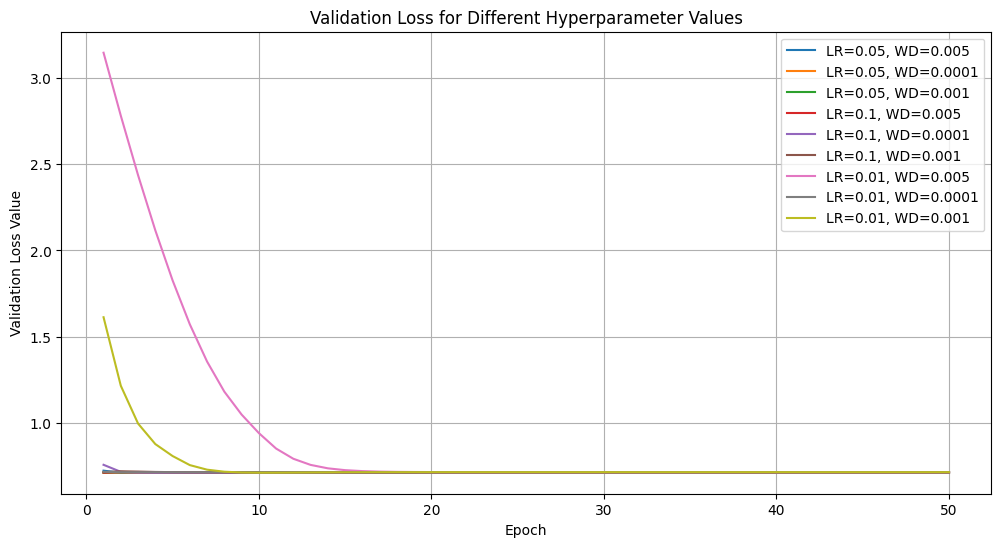

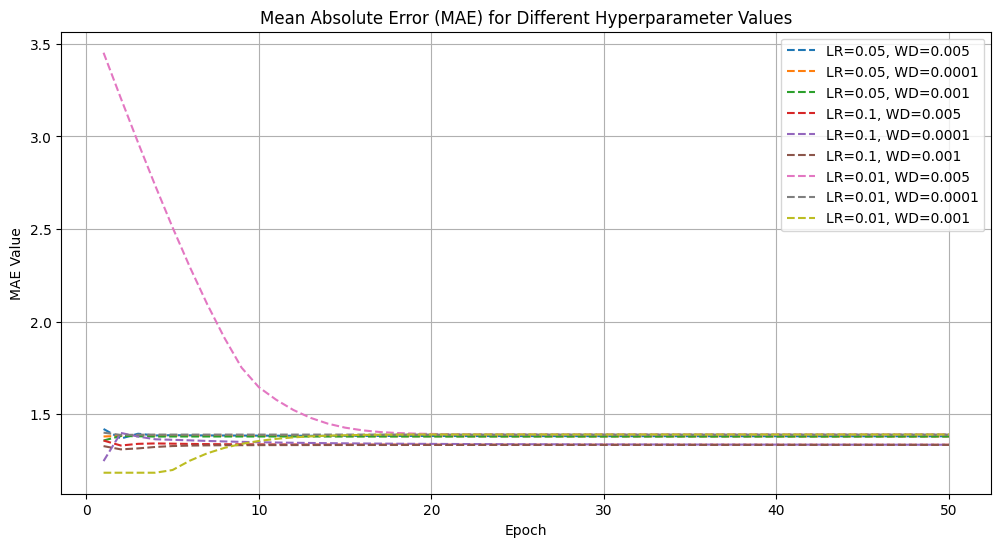

Best Hyperparameters: {'lr': 0.1, 'weight_decay': 0.0001}


In [18]:
import itertools

loss_function = "poisson"
learning_rates = [0.05, 0.1, 0.01]
weight_decays = [0.005, 0.0001,0.001]

num_epochs = 50
batch_size = 32

best_loss = float('inf')
best_hyperparameters = {}
epochs = range(1, num_epochs + 1)
all_val_maes,all_val_losses =[],[]

def calculate_mae(predictions, targets):
    return torch.mean(torch.abs(predictions - targets))


# Perform grid search
for lr, weight_decay in itertools.product(learning_rates, weight_decays):
    with mlflow.start_run():

        model = MeanModel()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        train_size = int(0.8 * n)
        train_stocks, train_demand, train_sales = stocks[:train_size], demand[:train_size], sales[:train_size]
        val_stocks, val_demand, val_sales = stocks[train_size:], demand[train_size:], sales[train_size:]
        val_losses = []
        mae_epoch = [] 


        for epoch in range(num_epochs):
            
            # Training loop
            for i in range(0, train_size, batch_size):
                batch_stocks = train_stocks[i:i + batch_size]
                batch_demand = train_demand[i:i + batch_size]
                batch_sales = train_sales[i:i + batch_size]

                optimizer.zero_grad()
                outputs = model(len(batch_stocks))
                loss = forecast_loss(outputs, batch_sales, batch_stocks, loss_function)
                loss.backward()
                optimizer.step()

            # Validation loop
            model.eval()
            val_outputs = model(len(val_stocks))
            val_loss = forecast_loss(val_outputs, val_sales, val_stocks, loss_function)
            val_losses.append(val_loss.item())
        
            # Calculate MAE during validation
            mae = torch.mean(torch.abs(val_outputs - val_sales))
            mae_epoch.append(mae.item())
            print(f"Epoch: {epoch}, Validation Loss: {val_loss.item()}, MAE: {mae.item()}")

            
            # Log metrics during each epoch
            mlflow.log_metric("MAE validation",  mae.item(), step=epoch)
            mlflow.log_metric("poisson_loss validation ", val_loss.item(), step=epoch)

            #get hyper params for best loss
            if val_loss < best_loss:
                best_loss = val_loss
                best_hyperparameters = {'lr': lr, 'weight_decay': weight_decay}

           
        mlflow.log_params({"best_lr": best_hyperparameters['lr'], "best_weight_decay": best_hyperparameters['weight_decay']})
        mlflow.log_params({"lr": lr, "weight_decay": weight_decay})
        mlflow.log_metric("best validation loss",best_loss)
        mlflow.pytorch.log_model(model, "models")

        all_val_losses.append(val_losses)
        all_val_maes.append(mae_epoch)


# plot loss
plt.figure(figsize=(12, 6))
for i, (lr, weight_decay) in enumerate(itertools.product(learning_rates, weight_decays)):
    plt.plot(range(1, num_epochs + 1), all_val_losses[i], label=f'LR={lr}, WD={weight_decay}')

plt.title('Validation Loss for Different Hyperparameter Values')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss Value')
plt.legend()
plt.grid(True)
plt.show()

# plot MAE 
plt.figure(figsize=(12, 6))
for i, (lr, weight_decay) in enumerate(itertools.product(learning_rates, weight_decays)):
    plt.plot(range(1, num_epochs + 1), all_val_maes[i], label=f'LR={lr}, WD={weight_decay}', linestyle='--')

plt.title('Mean Absolute Error (MAE) for Different Hyperparameter Values')
plt.xlabel('Epoch')
plt.ylabel('MAE Value')
plt.legend()
plt.grid(True)
plt.show()

print("Best Hyperparameters:", best_hyperparameters)



In [22]:
model.mean

Parameter containing:
tensor([0.5873], requires_grad=True)